In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation

from mylib.mygraph import graph

# Enable interactive plot
#%matplotlib notebook

## 1. create all frames

In [2]:
# there are two arrays to deal with in this program: 'scene' and 'frame'.
# 'scene' holds the compressed information of wether each block is white or black.
# 'frame' is a larger version of 'scene' used for visualizaion;
# each block of 'frame' corresponds to one entry of 'scene'.

# below method generates 'scene' based on primary information and draws 'frame' as well
def moving_bar(instance, bar_thickness=1, scene_sz=5, frame_sz=1024, plot=False, ax=None):
    # calculate size of each block in the frame corresponding to each entry of the scene
    rec_sz = frame_sz//scene_sz
    
    # prepare the scene
    bar_pos = instance%scene_sz
    scene = np.zeros((scene_sz,scene_sz))
    scene[:,bar_pos:bar_pos+bar_thickness] = 1

    if plot:
        # prepare frame based on the scene
        frame = 255 * np.ones(shape=[frame_sz, frame_sz, 3], dtype=np.uint8)
        for i in range(scene_sz):
            for j in range(scene_sz):
                cv2.rectangle(frame, pt1=(rec_sz*j,rec_sz*i), pt2=(rec_sz*(j+1),rec_sz*(i+1)), color=(255*(1-scene[i,j]),255*(1-scene[i,j]),255*(1-scene[i,j])), thickness= -1)

        # show frame
        ax.imshow(frame)
    
    return scene

array([[1., 1., 1., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 0., 0.]])

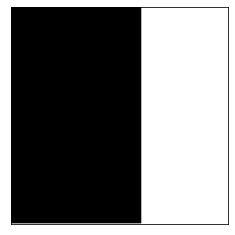

In [3]:
# test above function
#fig = plt.figure(figsize=[6,6])
fig, ax = plt.subplots()
plt.xticks([])
plt.yticks([])
moving_bar(instance=0, bar_thickness=3, scene_sz=5, frame_sz=1024, plot=True, ax=ax)

In [4]:
# generate all possible scenes
scene_sz = 5
scenes = np.array([moving_bar(instance=0,  bar_thickness=3, scene_sz=scene_sz, frame_sz=1024, plot=False, ax=None)])

for i in range(1, scene_sz):
    scenes = np.append(scenes, [moving_bar(instance=i,  bar_thickness=3, scene_sz=scene_sz, frame_sz=1024, plot=False, ax=None)], axis=0)

scenes    

array([[[1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0.]],

       [[0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.]],

       [[0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.]],

       [[0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 1.]],

       [[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]]])

## 2. create the underlying graph

In [5]:
def create_star_graph(scene_sz, show_msgs=True):
    g = graph()
    for i in range(scene_sz**2):
        g.addVertex()
    for i in range(scene_sz):
        for j in range(scene_sz):
            center = i*scene_sz+j
            for k in [-1,1]:
                # left and right nodes
                if (j!=0 or k==1) and (j<scene_sz-1 or k==-1):
                    g.addEdge((center, center+k), show_msgs=show_msgs)

                #up and down nodes
                if (i!=0 or k==1) and (i<scene_sz-1 or k==-1):
                    g.addEdge((center, center+k*scene_sz), show_msgs=show_msgs)

                #right-up and right-down nodes
                if (i!=0 or k==1) and (i<scene_sz-1 or k==-1) and (j<scene_sz-1):
                    g.addEdge((center, center+k*scene_sz+1), show_msgs=show_msgs)

                #left-up and left-down nodes
                if (i!=0 or k==1) and (i<scene_sz-1 or k==-1) and (j!=0):
                    g.addEdge((center, center+k*scene_sz-1), show_msgs=show_msgs)

    return g

In [6]:
def test_create_star_graph():
    g = create_star_graph(scene_sz=3)
    assert g.vertices()==[0, 1, 2, 3, 4, 5, 6, 7, 8]
    assert g.dictionary()[0] == {'out': [(0, 1), (0, 3), (0, 4)], 'in': [(1, 0), (3, 0), (4, 0)]}
    assert g.dictionary()[1] == {'out': [(1, 0), (1, 2), (1, 4), (1, 5), (1, 3)], \
                                 'in': [(0, 1), (2, 1), (3, 1), (4, 1), (5, 1)]}
    assert g.dictionary()[2] == {'out': [(2, 1), (2, 5), (2, 4)], 'in': [(1, 2), (4, 2), (5, 2)]}
    assert g.dictionary()[3] == {'out': [(3, 0), (3, 1), (3, 4), (3, 6), (3, 7)], \
                                 'in': [(0, 3), (1, 3), (4, 3), (6, 3), (7, 3)]}
    assert g.dictionary()[4] == {'out': [(4, 3), (4, 1), (4, 2), (4, 0), (4, 5), (4, 7), (4, 8), (4, 6)], \
                                 'in': [(0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (6, 4), (7, 4), (8, 4)]}
    assert g.dictionary()[5] == {'out': [(5, 4), (5, 2), (5, 1), (5, 8), (5, 7)], \
                                 'in': [(1, 5), (2, 5), (4, 5), (7, 5), (8, 5)]}
    assert g.dictionary()[6] == {'out': [(6, 3), (6, 4), (6, 7)], 'in': [(3, 6), (4, 6), (7, 6)]}
    assert g.dictionary()[7] == {'out': [(7, 6), (7, 4), (7, 5), (7, 3), (7, 8)], \
                                 'in': [(3, 7), (4, 7), (5, 7), (6, 7), (8, 7)]}
    assert g.dictionary()[8] == {'out': [(8, 7), (8, 5), (8, 4)], 'in': [(4, 8), (5, 8), (7, 8)]}
#     for i in range(9):
#         print(g.dictionary()[i])
    
test_create_star_graph()

In [7]:
def create_grid_graph(scene_sz, show_msgs=True):
    g = graph()
    for i in range(scene_sz**2):
        g.addVertex()
    for i in range(scene_sz):
        for j in range(scene_sz):
            center = i*scene_sz+j
            for k in [-1,1]:
                # left and right nodes
                if (j!=0 or k==1) and (j<scene_sz-1 or k==-1):
                    g.addEdge((center, center+k), show_msgs=show_msgs)

                #up and down nodes
                if (i!=0 or k==1) and (i<scene_sz-1 or k==-1):
                    g.addEdge((center, center+k*scene_sz), show_msgs=show_msgs)
    return g

In [8]:
def test_create_grid_graph():
    g = create_grid_graph(scene_sz=3)
    assert g.vertices()==[0, 1, 2, 3, 4, 5, 6, 7, 8]
    assert g.dictionary()[0] == {'out': [(0, 1), (0, 3)], 'in': [(1, 0), (3, 0)]}
    assert g.dictionary()[1] == {'out': [(1, 0), (1, 2), (1, 4)], 'in': [(0, 1), (2, 1), (4, 1)]}
    assert g.dictionary()[2] == {'out': [(2, 1), (2, 5)], 'in': [(1, 2), (5, 2)]}
    assert g.dictionary()[3] == {'out': [(3, 0), (3, 4), (3, 6)], 'in': [(0, 3), (4, 3), (6, 3)]}
    assert g.dictionary()[4] == {'out': [(4, 3), (4, 1), (4, 5), (4, 7)], \
                                 'in': [(1, 4), (3, 4), (5, 4), (7, 4)]}
    assert g.dictionary()[5] == {'out': [(5, 4), (5, 2), (5, 8)], 'in': [(2, 5), (4, 5), (8, 5)]}
    assert g.dictionary()[6] == {'out': [(6, 3), (6, 7)], 'in': [(3, 6), (7, 6)]}
    assert g.dictionary()[7] == {'out': [(7, 6), (7, 4), (7, 8)], 'in': [(4, 7), (6, 7), (8, 7)]}
    assert g.dictionary()[8] == {'out': [(8, 7), (8, 5)], 'in': [(5, 8), (7, 8)]}
#     for i in range(9):
#         print(g.dictionary()[i])
    
test_create_grid_graph()

In [9]:
# extract motion cues out of a series of scenes using a star graph
def motion_cues_on_star_graph(scenes):
    scene_sz = scenes.shape[1]
    
    g1 = create_star_graph(scene_sz=scene_sz) # scene in t==1
    g2 = create_star_graph(scene_sz=scene_sz) # scene in t==2
    motion_graphs = []
    
    for t in range(len(scenes)-1):
        # setup g1 and g2
        for i in range(scene_sz):
            for j in range(scene_sz):
                current = i*scene_sz+j
                g1.setVertexWeight(vrtx=current, weight=scenes[t][i][j])
                g2.setVertexWeight(vrtx=current, weight=scenes[t+1][i][j])
        for e in g1.edges():
            (v1, v2) = e
            diff = g1.getVertexWeight(vrtx=v2) - g1.getVertexWeight(vrtx=v1)
            g1.setEdgeWeight(edge=e, weight=diff)
            diff = g2.getVertexWeight(vrtx=v2) - g2.getVertexWeight(vrtx=v1)
            g2.setEdgeWeight(edge=e, weight=diff)
        
        # extract motion cues
        gm = create_star_graph(scene_sz=scene_sz) # motion from t==1 to t==2
        for e in g1.edges():
            (vrtx1, vrtx2) = e
            diff = g2.getEdgeWeight(edge=e) - g1.getEdgeWeight(edge=e)
            if diff>0 and g1.getVertexWeight(vrtx1)==1 and g2.getVertexWeight(vrtx2)==1:
                gm.setEdgeWeight(edge=e, weight=diff)
            else:
                gm.setEdgeWeight(edge=e, weight=0)
        motion_graphs.append(gm)
            
    return motion_graphs

In [10]:
# extract motion cues out of a series of scenes using a grid graph
def motion_cues_on_grid_graph(scenes):
    scene_sz = scenes.shape[1]
    
    g1 = create_grid_graph(scene_sz=scene_sz) # scene in t==1
    g2 = create_grid_graph(scene_sz=scene_sz) # scene in t==2
    motion_graphs = []
    
    for t in range(len(scenes)-1):
        # setup g1 and g2
        for i in range(scene_sz):
            for j in range(scene_sz):
                current = i*scene_sz+j
                g1.setVertexWeight(vrtx=current, weight=scenes[t][i][j])
                g2.setVertexWeight(vrtx=current, weight=scenes[t+1][i][j])
        for e in g1.edges():
            (v1, v2) = e
            diff = g1.getVertexWeight(vrtx=v2) - g1.getVertexWeight(vrtx=v1)
            g1.setEdgeWeight(edge=e, weight=diff)
            diff = g2.getVertexWeight(vrtx=v2) - g2.getVertexWeight(vrtx=v1)
            g2.setEdgeWeight(edge=e, weight=diff)
        
        # extract motion cues
        gm = create_grid_graph(scene_sz=scene_sz) # motion from t==1 to t==2
        for e in g1.edges():
            (vrtx1, vrtx2) = e
            diff = g2.getEdgeWeight(edge=e) - g1.getEdgeWeight(edge=e)
            if diff>0 and g1.getVertexWeight(vrtx1)==1 and g2.getVertexWeight(vrtx2)==1:
                gm.setEdgeWeight(edge=e, weight=diff)
            else:
                gm.setEdgeWeight(edge=e, weight=0)
        motion_graphs.append(gm)
            
    return motion_graphs

In [11]:
# test motion graphs
def test_motion_cues_on_grid_graph(show_msgs=True):
    # generate all possible scenes
    scene_sz = 3
    scenes = np.array([moving_bar(instance=0, bar_thickness=2, scene_sz=scene_sz, frame_sz=1024, plot=False, ax=None)])
    for i in range(1, scene_sz):
        scenes = np.append(scenes, [moving_bar(instance=i, bar_thickness=2, scene_sz=scene_sz, frame_sz=1024, plot=False, ax=None)], axis=0)

    # extract motion cues
    motion_graphs = motion_cues_on_grid_graph(scenes)
    
    # test
    gm = motion_graphs[0]
    for e in gm.edges():
        if e==(0,1) or e==(1,2) or e==(3,4) or e==(4,5) or e==(6,7) or e==(7,8):     
            assert gm.getEdgeWeight(e) == 1
        else:
            assert gm.getEdgeWeight(e) == 0
    
    gm = motion_graphs[1]
    for e in gm.edges():
        if e==(1,2) or e==(4,5) or e==(7,8):     
            assert gm.getEdgeWeight(e) == 1
        else:
            assert gm.getEdgeWeight(e) == 0

#     gm = motion_graphs[1]
#     # show all edges with non-zero weights
#     for e in gm.edges():
#         if gm.getEdgeWeight(e) != 0:
#             print('{} -> {}'.format(e, gm.getEdgeWeight(e)))

#     # show all edges with 2 or -2 weights
#     for e in gm.edges():
#         if gm.getEdgeWeight(e) == 2:
#             print('graph {}: {} -> {}'.format(gm, e, gm.getEdgeWeight(e)))
#     for e in gm.edges():
#         if gm.getEdgeWeight(e) == -2:
#             print('graph {}: {} -> {}'.format(gm, e, gm.getEdgeWeight(e)))
            

test_motion_cues_on_grid_graph(show_msgs=True)

In [12]:
# extract motion cues from a 5x5px moving bar movie
motion_graphs = motion_cues_on_grid_graph(scenes)
motion_graphs

## 3. predict next frame using current frame and motion cues

In [13]:
def predict_next(scenes, motion_graphs):
    scene_sz = scenes.shape[1]
    predictions = []
    
    for t in range(scene_sz-1):
        current_scene = scenes[t]
        current_motion_graph = motion_graphs[t]
        prediction = np.copy(current_scene)
        
        for e in current_motion_graph.edges():
            (vrtx1, vrtx2) = e
            if current_motion_graph.getEdgeWeight(e) > 0: # for each positively weighted edge
                prediction[vrtx2//scene_sz][vrtx2%scene_sz] = 1 # make tail vertex 1
            if current_scene[vrtx2//scene_sz][vrtx2%scene_sz]+current_motion_graph.getEdgeWeight(e) == 2:
                prediction[vrtx1//scene_sz][vrtx1%scene_sz] = 0 # make head vertex 0
                
        predictions.append(prediction)
    
    return predictions

predictions = predict_next(scenes, motion_graphs)
predictions

[array([[0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.]]),
 array([[0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.]]),
 array([[0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 1.]]),
 array([[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]])]

In [14]:
def assess_predictions(scenes, predictions):
    scene_sz = scenes.shape[1]
    
    accuracy = 0
    for t in range(1, scene_sz):
        accuracy = accuracy + np.sum(scenes[t] == predictions[t-1]) / scene_sz**2
    accuracy = accuracy / (scene_sz-1)
    
    return accuracy

accuracy = assess_predictions(scenes, predictions)
accuracy

1.0

In [63]:
# quick test area

a = np.array([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])

b = np. array([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]])
np.sum(a == b) / 5**2

0.6